In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from IPython.display import display

pd.set_option("display.max_columns", None)

In [2]:
cwd = Path().resolve()

if (cwd / "notebooks").exists():
    ROOT = cwd
elif (cwd.name == "notebooks"):
    ROOT = cwd.parent
else:
    ROOT = cwd

train = pd.read_csv(ROOT / "data/train.csv")
test = pd.read_csv(ROOT / "data/test.csv")

print(train.shape, test.shape)

(891, 12) (418, 11)


# **Titanic Survival EDA**
## <u>Index</u>
1) **Data Overview and Missing Values** – shape, types, first look, what needs imputation or dropping

2) **Numeric Features** – distributions, categorical group differences

3) **Categorical Features** – pairwise patterns and correlations

4) **Feature Relationships** – pairwise patterns and correlations


4) **Insights summary** – what to keep, drop, or engineer

## 1) <u>Data Overview</u>:

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### ~38% Overall Survival Rate

In [4]:
train["Survived"].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

#### Correlations:

<Axes: >

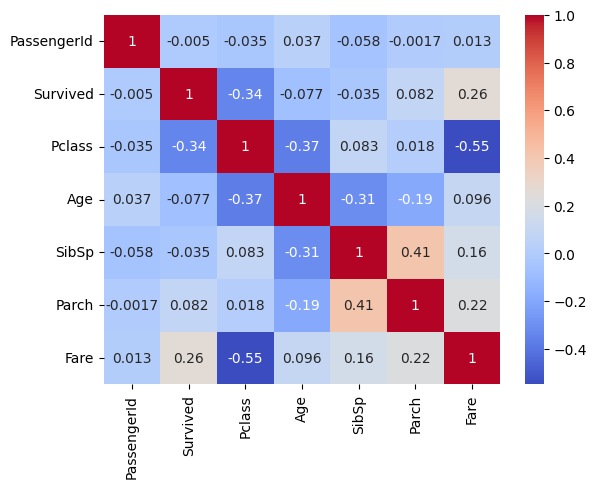

In [5]:
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="coolwarm")

### *Features with missing values*
- **Cabin** ~77% records missing but shows strong survival bias, addressed in the Categorical Features section
- **Age** ~20% missing, will be imputed using median
- **Embarked** ~0.2% missing, will be imputed using most common

In [6]:
m = train.isna().agg(["sum", "mean"]).T
print("Features with missing records:")
m[m["sum"]>0].sort_values(by="sum", ascending=False).rename(columns={"sum": "Records Missing", "mean": "Proportion Missing"})

Features with missing records:


,Records Missing,Proportion Missing
Cabin,687.0,0.771044
Age,177.0,0.198653
Embarked,2.0,0.002245


## 2) <u>Numeric features:</u>
- Pclass will be considered a categorical feature
- Parch (# of parents/children onboard) and SibSp (# of siblings/spouses onboard) are ordinal features
  - will be used later on to create family features.


In [7]:
train.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 3) <u>Categorical Features</u>:

#### Categorical columns including the Pclass column. A number of these are high cardinality.

In [8]:
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols.append("Pclass")

for col in cat_cols:
    print(f"{col}: {train[col].nunique()} unique values")

Name: 891 unique values
Sex: 2 unique values
Ticket: 681 unique values
Cabin: 147 unique values
Embarked: 3 unique values
Pclass: 3 unique values


In [9]:
low_card_cols = [c for c in cat_cols if train[c].nunique() < 10]
high_card_cols = [c for c in cat_cols if c not in low_card_cols]
low_card_cols, high_card_cols

(['Sex', 'Embarked', 'Pclass'], ['Name', 'Ticket', 'Cabin'])

#### Gender has a strong relationship with survival. Embarked is weak when isolated on its own.

In [10]:
for c in low_card_cols:
    print(train.groupby(c)["Survived"].mean())
    print("\n")

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64




#### Cabin is sparsely populated. Age is missing 20% and may correlate with class & survival, first pass with median. Embarked will be imputed with most common.

In [11]:
mp = train.isna().mean().sort_values(ascending=False)
print("Proportion of records missing:")
mp[mp>0]

Proportion of records missing:


Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

#### Cabin meaningfully contributes to survival rate

In [12]:
train["CabinFlag"] = train["Cabin"].notna().astype(int)
train.groupby("CabinFlag")["Survived"].mean()

CabinFlag
0    0.299854
1    0.666667
Name: Survived, dtype: float64

#### Cabin has 147 different possible values but appears to be grouped by Deck letter

In [13]:
c = train["Cabin"].dropna().unique()
print(c.shape[0], "unqiue records.\n")
print(c)

147 unqiue records.

['C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33' 'B30'
 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']


#### There is some insight provided by deck but some decks have few records which may cause unnecessary noise. To consider grouping into a "Rare" bucket value. To revisit later to see if simplified group encoding improves validation accuracy.

In [14]:

train["Deck"] = train["Cabin"].dropna().str[0]
display(
    "Deck proportions:",
    train["Deck"].value_counts(normalize=True).sort_values(ascending=False),
    "Deck survival rate and count:",
    train.groupby("Deck")["Survived"].agg(["mean", "count"])
)

'Deck proportions:'

Deck
C    0.289216
B    0.230392
D    0.161765
E    0.156863
A    0.073529
F    0.063725
G    0.019608
T    0.004902
Name: proportion, dtype: float64

'Deck survival rate and count:'

,mean,count
Deck,,
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
T,0.000000,1


#### Name is high cardinality but generally follows a "Lastname, Title. Firstname" format. Title can be extracted and may provide insight

In [15]:
n = train["Name"].sample(10)
print("Sample Names:\n")
display(n)

train["Title"] = train["Name"].str.extract(r",\s*([^\.]+)\.")

print("Titles Extracted:")
train["Title"].value_counts()

Sample Names:



499                                   Svensson, Mr. Olof
102                            White, Mr. Richard Frasar
175                               Klasen, Mr. Klas Albin
623                          Hansen, Mr. Henry Damsgaard
341                       Fortune, Miss. Alice Elizabeth
21                                 Beesley, Mr. Lawrence
733                           Berriman, Mr. William John
326                            Nysveen, Mr. Johan Hansen
72                                  Hood, Mr. Ambrose Jr
394    Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...
Name: Name, dtype: object

Titles Extracted:


Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

- Low count categories are bucketed to prevent overfitting
- Title provides strong correlation with Survival

In [16]:
title_map = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Lady": "Rare", "the Countess": "Rare", "Capt": "Rare",
    "Col": "Rare", "Don": "Rare", "Dr": "Rare", "Major": "Rare",
    "Rev": "Rare", "Sir": "Rare", "Jonkheer": "Rare"
}
train["Title"] = train["Title"].replace(title_map)
t = pd.DataFrame({
    "Count": train["Title"].value_counts(),
    "Proportion": train["Title"].value_counts(normalize=True),
    "Survival": train.groupby("Title")["Survived"].mean()
})
t.sort_values("Survival", ascending=False)

,Count,Proportion,Survival
Title,,,
Mrs,126,0.141414,0.793651
Miss,185,0.207632,0.702703
Master,40,0.044893,0.575000
Rare,23,0.025814,0.347826
Mr,517,0.580247,0.156673


#### Fare is heavily skewed and correlates with Pclass

<Axes: xlabel='Fare', ylabel='Count'>

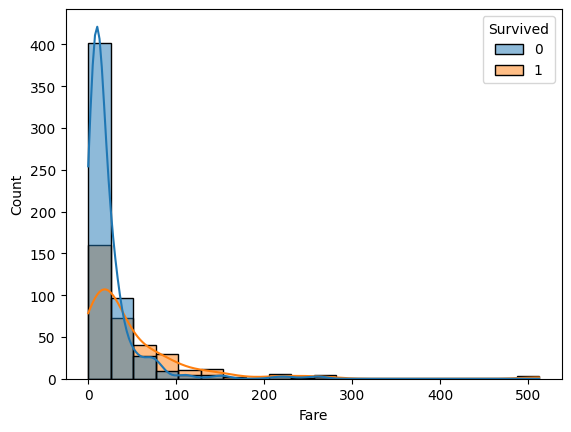

In [17]:
sns.histplot(data=train, x="Fare", hue="Survived", bins=20, kde=True)

#### Age correlates with survival depending on the age group. Could consider categorizing age groups into bins.

<Axes: xlabel='Age', ylabel='Count'>

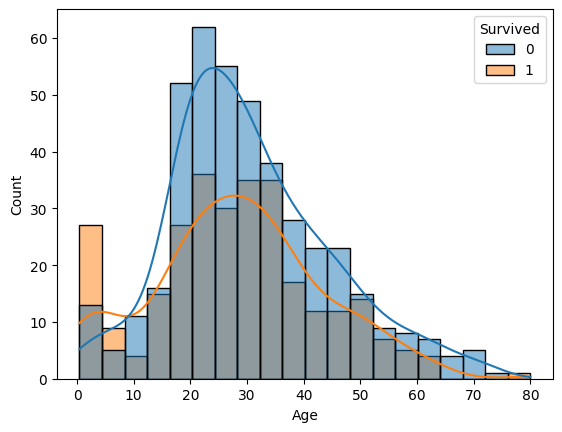

In [18]:
sns.histplot(data=train, x="Age", hue="Survived", bins=20, kde=True)

<Axes: xlabel='AgeGroup', ylabel='Count'>

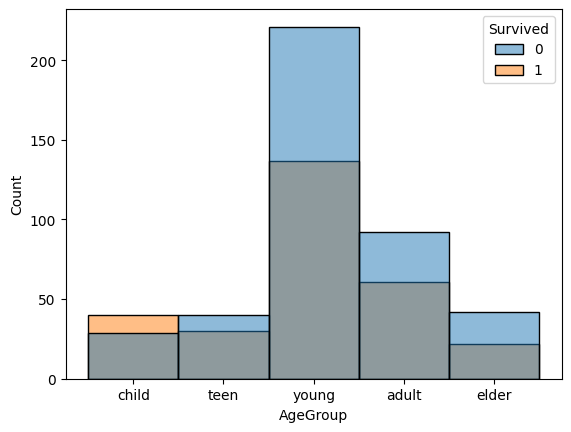

In [19]:
train["AgeGroup"] = pd.cut(train["Age"], bins=[0,12,18,35,50,80], labels=["child","teen","young","adult","elder"])
sns.histplot(data=train, x="AgeGroup", hue="Survived")

Pclass is ordinal and correlates with Survival


<Axes: xlabel='Pclass', ylabel='Survived'>

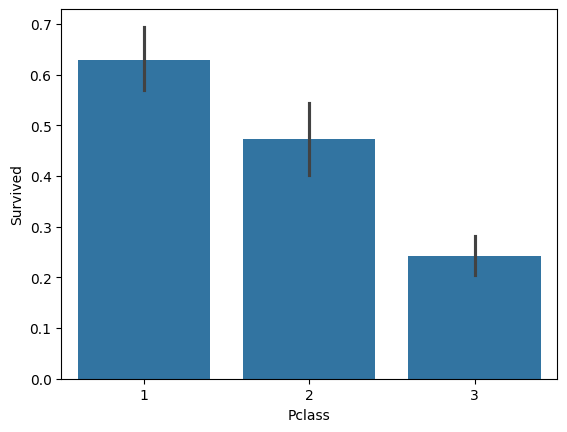

In [20]:
sns.barplot(data=train, x="Pclass", y="Survived")

In [21]:
pd.crosstab(train["Pclass"], train["Sex"], values=train["Survived"], aggfunc="mean")

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


Alone vs family travelling strongly affects survival odds

In [22]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)

<Axes: xlabel='IsAlone', ylabel='Survived'>

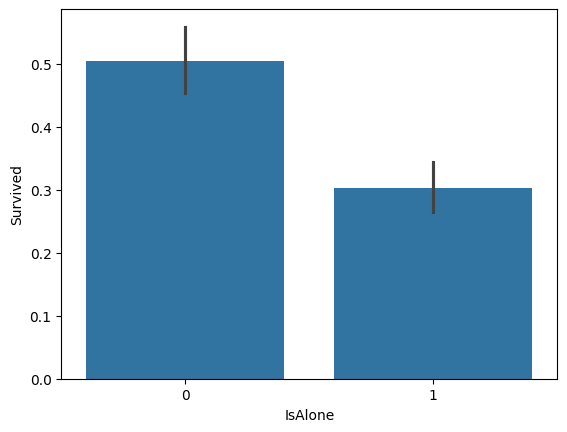

In [23]:
sns.barplot(data=train, x="IsAlone", y="Survived")

In [24]:
for col in ["Title", "CabinFlag"]:
    print(train.groupby(col)["Survived"].mean())

Title
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.793651
Rare      0.347826
Name: Survived, dtype: float64
CabinFlag
0    0.299854
1    0.666667
Name: Survived, dtype: float64


## 5) <u>Feature Relationships</u>

In [25]:
corrs = train.corr(numeric_only=True)["Survived"].sort_values(ascending=False)
corrs

Survived       1.000000
CabinFlag      0.316912
Fare           0.257307
Parch          0.081629
FamilySize     0.016639
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
IsAlone       -0.203367
Pclass        -0.338481
Name: Survived, dtype: float64

#### Numeric correlations with survival

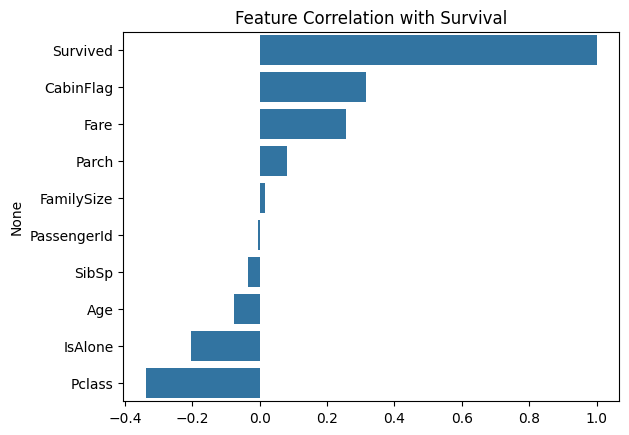

In [26]:
sns.barplot(x=corrs.values, y=corrs.index, orient="h")
plt.title("Feature Correlation with Survival")
plt.show()

#### Categorical correlations with survival

In [27]:
for col in ["Sex", "Pclass", "Embarked", "Title"]:
    print(train.groupby(col)["Survived"].mean().sort_values(ascending=False), "\n")

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64 

Title
Mrs       0.793651
Miss      0.702703
Master    0.575000
Rare      0.347826
Mr        0.156673
Name: Survived, dtype: float64 



## 6) <u>Insights Summary</u>

- **Fare** — wealth indicator; skewed distribution, higher fares → higher survival
- **Age** — life-stage proxy; children prioritized during evacuation
- **Pclass** — socioeconomic marker; strongly predictive of survival
- **Family features** (**SibSp, Parch, FamilySize, IsAlone**) — social context; being alone reduces survival odds
- **Title** (from **Name**) — captures gender and social status; highly predictive
- **CabinFlag** — access/location proxy; strong binary signal for survival